#### Assignment

Use the example of "AIF360/examples/tutorial_medical_expenditure.ipynb", 

ref. https://github.com/Trusted-AI/AIF360/blob/e011686ba3d30cd21e04219e502fe33a74ab3817/examples/tutorial_medical_expenditure.ipynb

for further examining bias for a trained RandomForestClassifier on the salary_classification dataset.

Two of the datasets used in "tutorial_medical_expenditure.ipynb" are available in the documents section in Chamilo. (ref. h181.zip & h192.zip)


Calculate the following metrics:
- 1-min(DI, 1/DI) 
- average odds difference value
- statistical parity difference value
- equal opportunity difference value
- Theil index value

Calculate those metrics on:
- the original dataset,
- the dataset after using the reweighing bias mitigation technique,
- the dataset after using the prejudice remover technique.

Make sure you understand the use of and the difference between the following variables:
- protected_attribute_names,
- priviliged_classes,
- favorable_classes,
- privileged / unprivileged groups

In the GermanDataset (ref. https://github.com/Trusted-AI/AIF360/blob/main/aif360/datasets/german_dataset.py),  
for example, what are the label_maps and the protected_attribute_maps used for?

The ipynb "les8_4_salary_prediction_reworked.ipynb" contains a way of answering the above questions.

Remark that, in that reworked notebook, an aif360 dataset instance is created on the preprocessed data, before applying the train_test_split or before training any models.

You could also train and tune the models, before using the aif360 library, and then only use the libary to examine bias in the data / model.

In [1]:
!pip install -qU kagglehub

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import joblib
import matplotlib.pyplot as plt 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools
from IPython.display import Markdown, display

In [3]:
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
import itertools

pd.options.display.float_format = '{:.2f}'.format

import warnings                   # to deal with warnings
warnings.filterwarnings('ignore')

In [4]:
import kagglehub

# Download latest version
# ref. https://www.kaggle.com/datasets/ayessa/salary-prediction-classification/data
path = kagglehub.dataset_download("ayessa/salary-prediction-classification")

print("Path to dataset files:", path)

100%|██████████| 460k/460k [00:00<00:00, 1.12MB/s]

Extracting files...
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/ayessa/salary-prediction-classification/versions/1


In [10]:
# Read the data

In [5]:
df = pd.read_csv(os.path.join(path, 'salary.csv'))

In [11]:
# Explore the data

In [6]:
df.shape

(32561, 15)

In [198]:
for col in df.columns:
    print(col)

age
workclass
fnlwgt
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country
salary


In [199]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Check for duplicates

In [200]:
duplicates = df.duplicated().sum()
print(duplicates)

24


In [32]:
# Check for missing values
isna = df.isna().sum()
print(isna)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64


In [7]:
# Let's get rid of duplicate entries

df.drop_duplicates(keep='first',inplace=True)

In [44]:
# Again check the dataset shape, after removing the duplicate entries

print(f'Number of records (rows) in the dataset are: {df.shape[0]}')
print(f'Number of features (columns) in the dataset are: {df.shape[1]}')
print(f'Number of duplicate entries in the dataset are: {df.duplicated().sum()}')

Number of records (rows) in the dataset are: 32537
Number of features (columns) in the dataset are: 15
Number of duplicate entries in the dataset are: 0


In [8]:
# Let's check the labels in the categorical features

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())


workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

marital-status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

sex
[' Male' ' Female']

native-country
[' United-States' ' Cuba' ' Jamaica' ' 

Some Observations

It is observed that extra spaces are appearing everywhere in the dataset (you can see an extra space before first letter of each label in the above output)
It is also observed that ' ?' symbol is appearing in workclass, occupation, and native-country features.
Let's replace the symbol with 'nan' to add appropriate values in later steps.

In [9]:
# First we remove all the extra spaces across the dataset

# df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

## Now let's replace the '?' symbol with 'nan' throughout the dataset

df_filled = df.replace('?', np.nan, inplace=False)

# Check the dataset features with null values ('nan')

numer_of_na_s = pd.isna(df_filled).sum()[pd.isna(df_filled).sum() > 0]
print(f"numer_of_na_s: \n {numer_of_na_s}")

numer_of_na_s: 
 workclass         1836
occupation        1843
native-country     582
dtype: int64


Observations

Upon checking the dataset, it is understood that occupation is missing in a record, wherever the workclass is missing for that record.

The missing values reported are all missing values for categorical variables. Therefore it is good to create a particular label for those missing values, like the ' ?' from before, or for example "Unknown Other" or "missing".

In [10]:
df_ = df.replace('?', 'missing', inplace=False)

In [11]:
print(df.shape)

(32537, 15)


In [12]:
# let's rename (segregate) some labels in select features to 
   ## 1. rectify erros 
   ## 2. to consolidate
   ## 3. to shorten them for visualisation purpose

df = df.replace({'workclass': {'State-gov': 'Govt.', 'Self-emp-not-inc': 'self_emp', 'Federal-gov': 'Govt.', 'Local-gov': 'Govt.', 'Self-emp-inc':'self_emp', 'Without-pay': 'UnknCl', 'Never-worked': 'UnknCl'}}, inplace=False)
df = df.replace({'marital-status': {'Married-civ-spouse': 'Married', 'Divorced': 'DASW', 'Married-spouse-absent': 'DASW', 'Separated': 'DASW', 'Married-AF-spouse':'Married', 'Widowed': 'DASW'}}, inplace=False)
df = df.replace({'occupation': {'Adm-clerical': 'Adminstration', 'Exec-managerial': 'Executive', 'Handlers-cleaners': 'Handlers', 'Prof-specialty': 'Profesionals', 'Other-service' : 'UnknOc', 'Craft-repair' : 'Repairing', 'Farming-fishing' : 'Farming', 'Transport-moving':'Transportation', 'Machine-op-inspct': 'MachineOp', 'Protective-serv' : 'ProtectiveServ', 'Priv-house-serv': 'HouseServ'}}, inplace=False)
df = df.replace({'native-country': {'United-States': 'USA', 'South': 'SouthKorea', 'Puerto-Rico': 'PuertoRico', 'Dominican-Republic': 'DominicRep', 'Outlying-US(Guam-USVI-etc)':'OutlyingUSA', 'Trinadad&Tobago': 'Tri&Tob', 'Holand-Netherlands': 'Netherlands', 'Hong' : 'HongKong'}}, inplace=False)
df = df.replace({'race': {'Asian-Pac-Islander': 'APAC', 'Amer-Indian-Eskimo': 'NatAm'}}, inplace=False)
## df.replace({'salary': {'<=50K': 0, '>50K': 1}}, inplace=True)

## Checking whether the modification has been made or not

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())
        


workclass
['Govt.' 'self_emp' 'Private' '?' 'UnknCl']

education
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

marital-status
['Never-married' 'Married' 'DASW']

occupation
['Adminstration' 'Executive' 'Handlers' 'Profesionals' 'UnknOc' 'Sales'
 'Repairing' 'Transportation' 'Farming' 'MachineOp' 'Tech-support' '?'
 'ProtectiveServ' 'Armed-Forces' 'HouseServ']

relationship
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race
['White' 'Black' 'APAC' 'NatAm' 'Other']

sex
['Male' 'Female']

native-country
['USA' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'SouthKorea' 'PuertoRico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Italy'
 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan'
 'Haiti' 'Portugal' 'DominicRep' 'El-Salvador' 'France' 'Guatemala'
 'China' 'Japan' 'Yugoslavia' 'Peru' 'OutlyingUSA' 'Scotl

In [59]:
# Since many native countries are there, we will check the records to understand the trend 
# and make modification if needed

df['native-country'].value_counts()

native-country
USA            29153
Mexico           639
missing          582
Philippines      198
Germany          137
Canada           121
PuertoRico       114
El-Salvador      106
India            100
Cuba              95
England           90
Jamaica           81
SouthKorea        80
China             75
Italy             73
DominicRep        70
Vietnam           67
Japan             62
Guatemala         62
Poland            60
Columbia          59
Taiwan            51
Haiti             44
Iran              43
Portugal          37
Nicaragua         34
Peru              31
France            29
Greece            29
Ecuador           28
Ireland           24
HongKong          20
Cambodia          19
Tri&Tob           19
Laos              18
Thailand          18
Yugoslavia        16
OutlyingUSA       14
Honduras          13
Hungary           13
Scotland          12
Netherlands        1
Name: count, dtype: int64

It appears that USA is the top native country, and has highest number of records, somewhere around 90% of total records.

In [13]:
# We'll make two separate dataframes for native country feature, for use in visualisations.

USA = df[df['native-country'] == 'USA']
NonUSA = df[df['native-country'] != 'USA']

print('USA', USA.shape)
print('NonUSA', NonUSA.shape)

USA (29153, 15)
NonUSA (3384, 15)


In [14]:
# Before proceeding to EDA, let's have a glance at the dataframe using -
# info() and describe() functions

print(df.info())
print(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  salary          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB
None
                  count unique           top   freq      mean       std  \
age            325

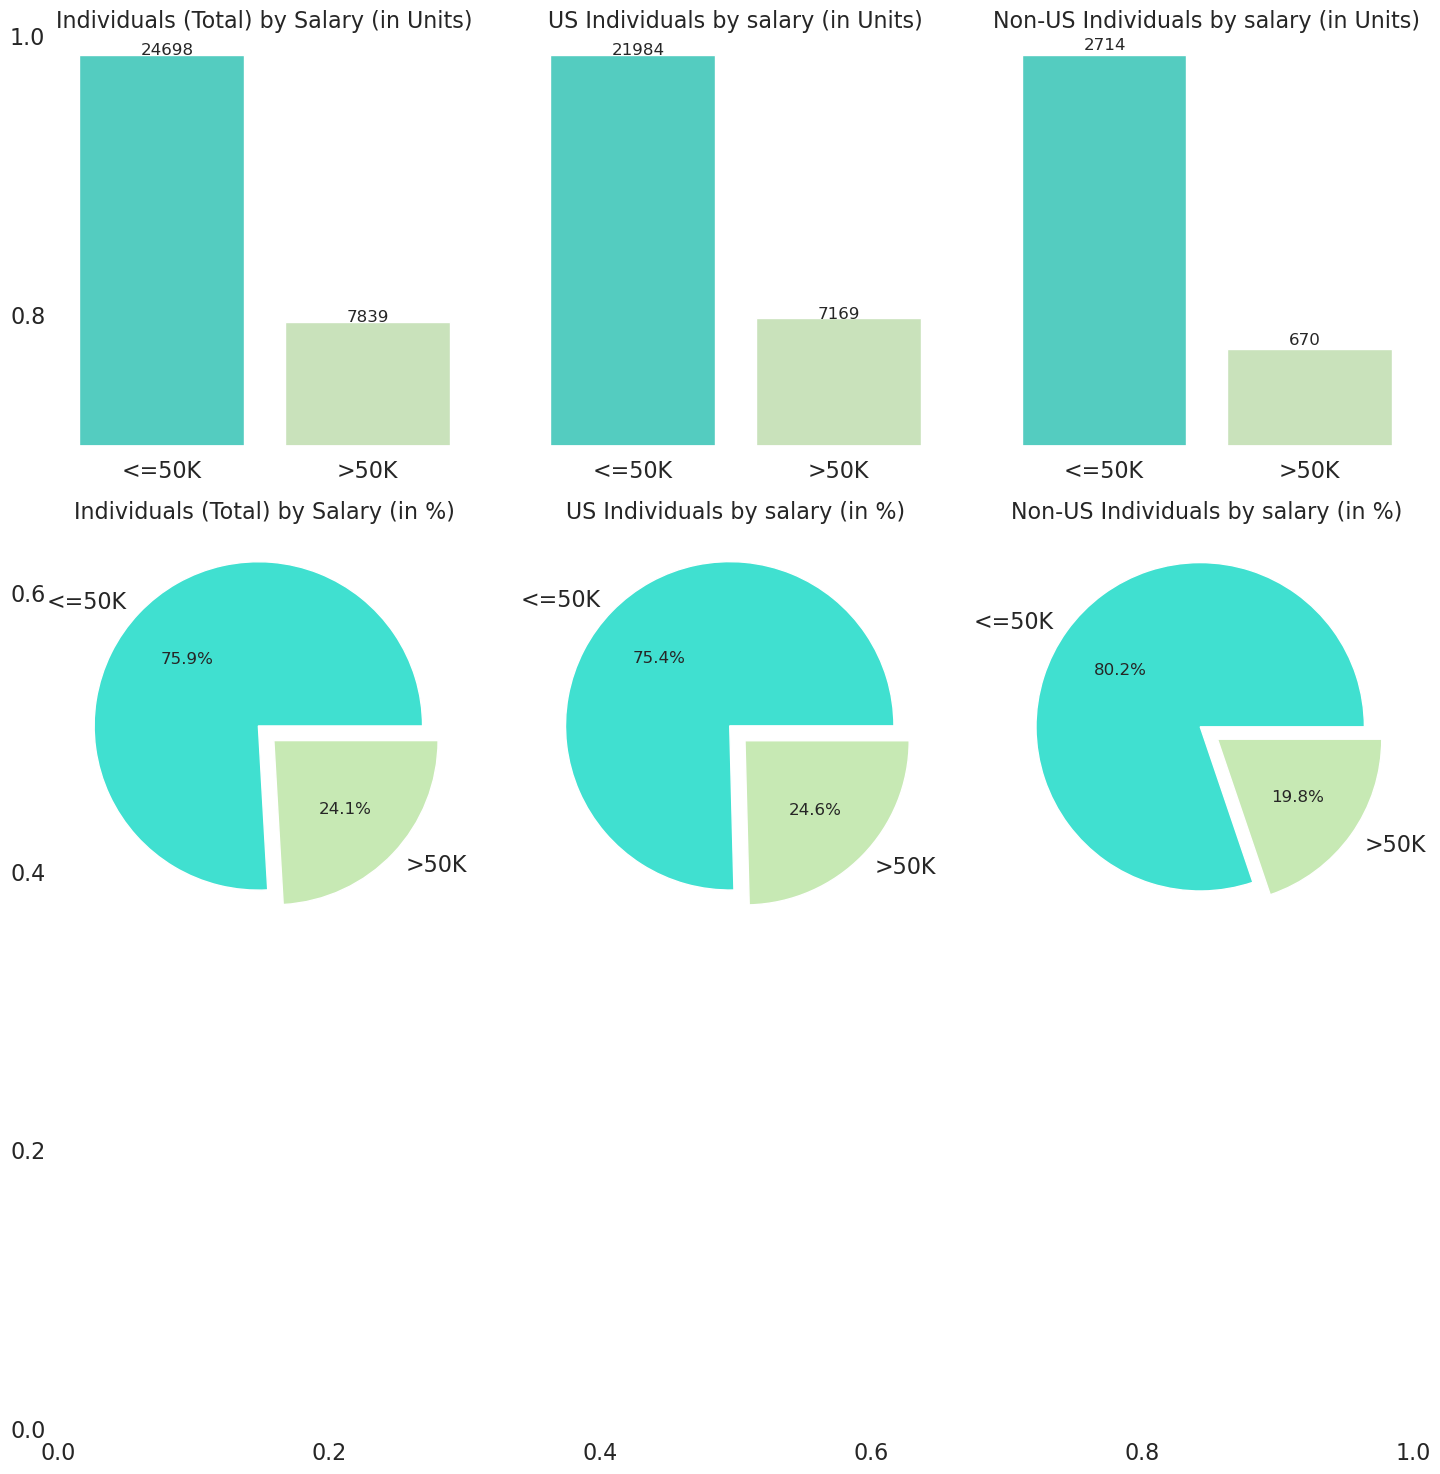

In [51]:
## Now, we will start our EDA (Exploratory Data Analysis)

## Let's take a deeper look into SALARY (the target variable in our dataset)

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':16,'ytick.labelsize':16, 'figure.autolayout':True})
my_pal = ('#40E0D0','#c7e9b4', '#EEE8AA', '#D2B48C', '#FAFAD2','#FAEBD7', '#D8BFD8','#F4A460','#F08080')
my_xpl = [0.05, 0.08]

plt.subplots(figsize=(15,15))

## Total Individuals by Salary (in Units)
plt.subplot(3,3,1)
plt.title('Individuals (Total) by Salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=df, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## US Individuals by Salary (in Units)
plt.subplot(3,3,2)
plt.title('US Individuals by salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=USA, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## Non-US Individuals by Salary (in Units)
plt.subplot(3,3,3)
plt.title('Non-US Individuals by salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=NonUSA, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))

plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## Total Individuals by Salary (in %)
plt.subplot(3,3,4)
plt.title('Individuals (Total) by Salary (in %)', fontsize=16)
df['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## US Individuals by Salary (in %)
plt.subplot(3,3,5)
plt.title('US Individuals by salary (in %)', fontsize=16)
USA['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Non US Individuals by Salary (in %)
plt.subplot(3,3,6)
plt.title('Non-US Individuals by salary (in %)', fontsize=16)
NonUSA['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

plt.show()

Some Observations

It appears that the dataset is somewhat imbalanced as over 3/4th of the records belong to <=50k salary segment. The >50k salary segment is just around 24%.

Furthermore, it is observed that USA has a higher number of over 50k salaried individuals at around 24%, which is at par with the overall share.

In NonUSA countries segment, share of below 50k salary salaried indivisuals is higher than overall (USA + NonUSA) share, at around 80%.

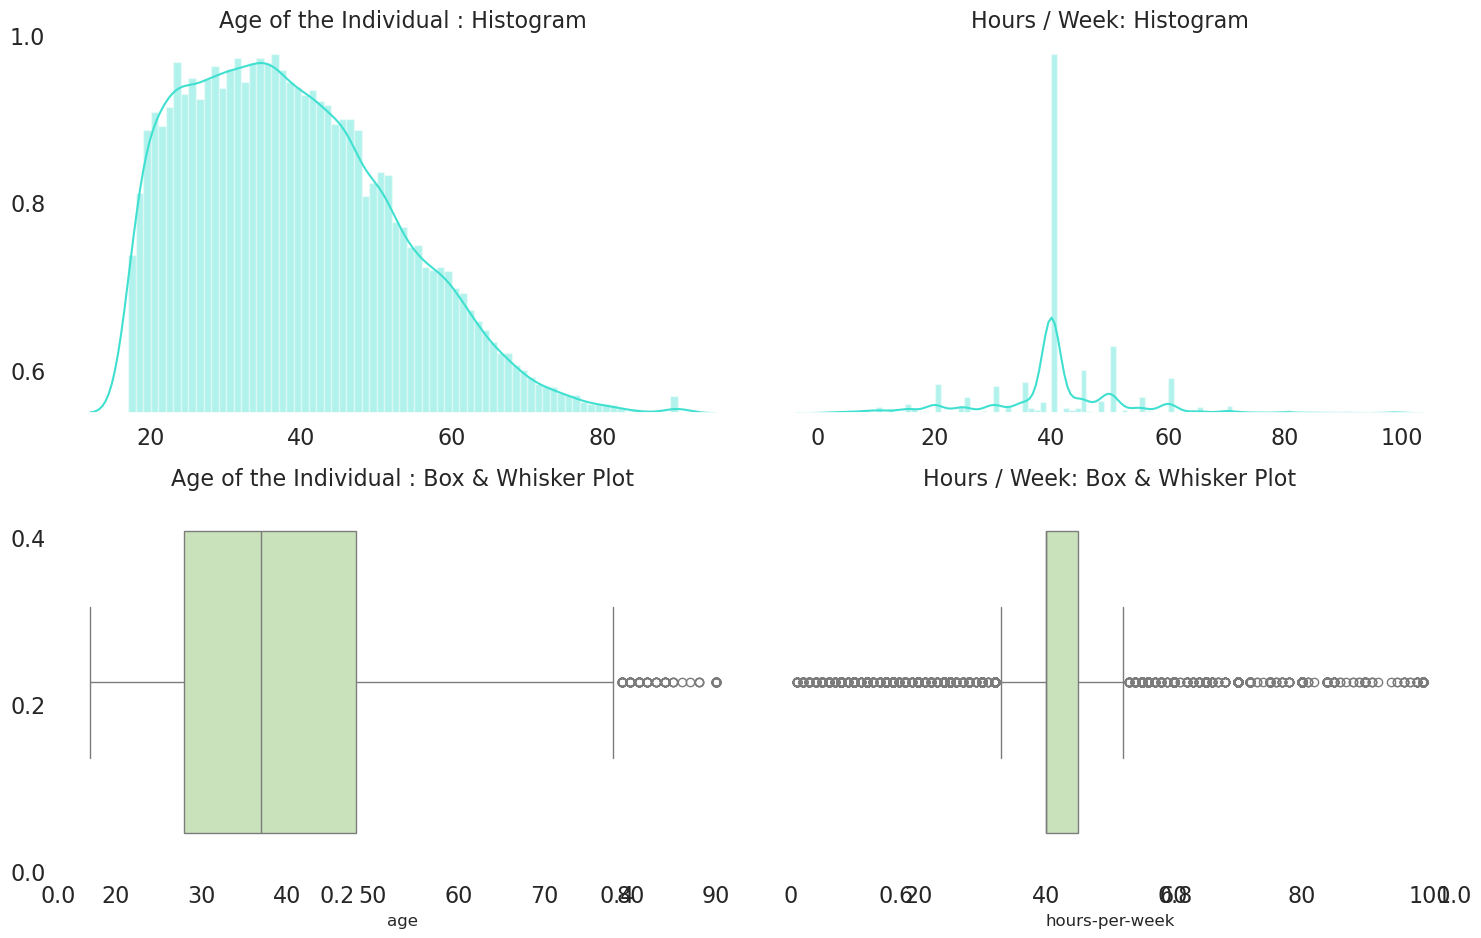

In [211]:
## Now Let's do some analysis of numerical variables in our dataset
## Age and Hours worked / week are the two numerical variables we have here

## We analyse these variables with histograms and box & whisker plots to understand distribution and identify outliers

plt.subplots(figsize=(15,10))

plt.subplot(2,2,1)
plt.title('Age of the Individual : Histogram',fontsize=16)
sns.distplot(df.age, color='#40E0D0', bins=73)
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.subplot(2,2,2)
plt.title('Hours / Week: Histogram', fontsize=16)
sns.distplot(df['hours-per-week'], color='#40E0D0', bins=98)
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.subplot(2,2,3)
plt.title('Age of the Individual : Box & Whisker Plot', fontsize=16)
sns.boxplot(df['age'], orient='h',color="#c7e9b4")

plt.subplot(2,2,4)
plt.title('Hours / Week: Box & Whisker Plot', fontsize=16)
sns.boxplot(df['hours-per-week'], orient='h', color="#c7e9b4")

plt.show()

Some Observations

Both Age and Hours / week features have significant number of outliers.
In age feature, you can see individuals aged 70 years and above
Similarly, in hours / week feature, you can see individuals working for 70 hours or more.
even for self employed people, working for 70 hours / week is extremely difficult.

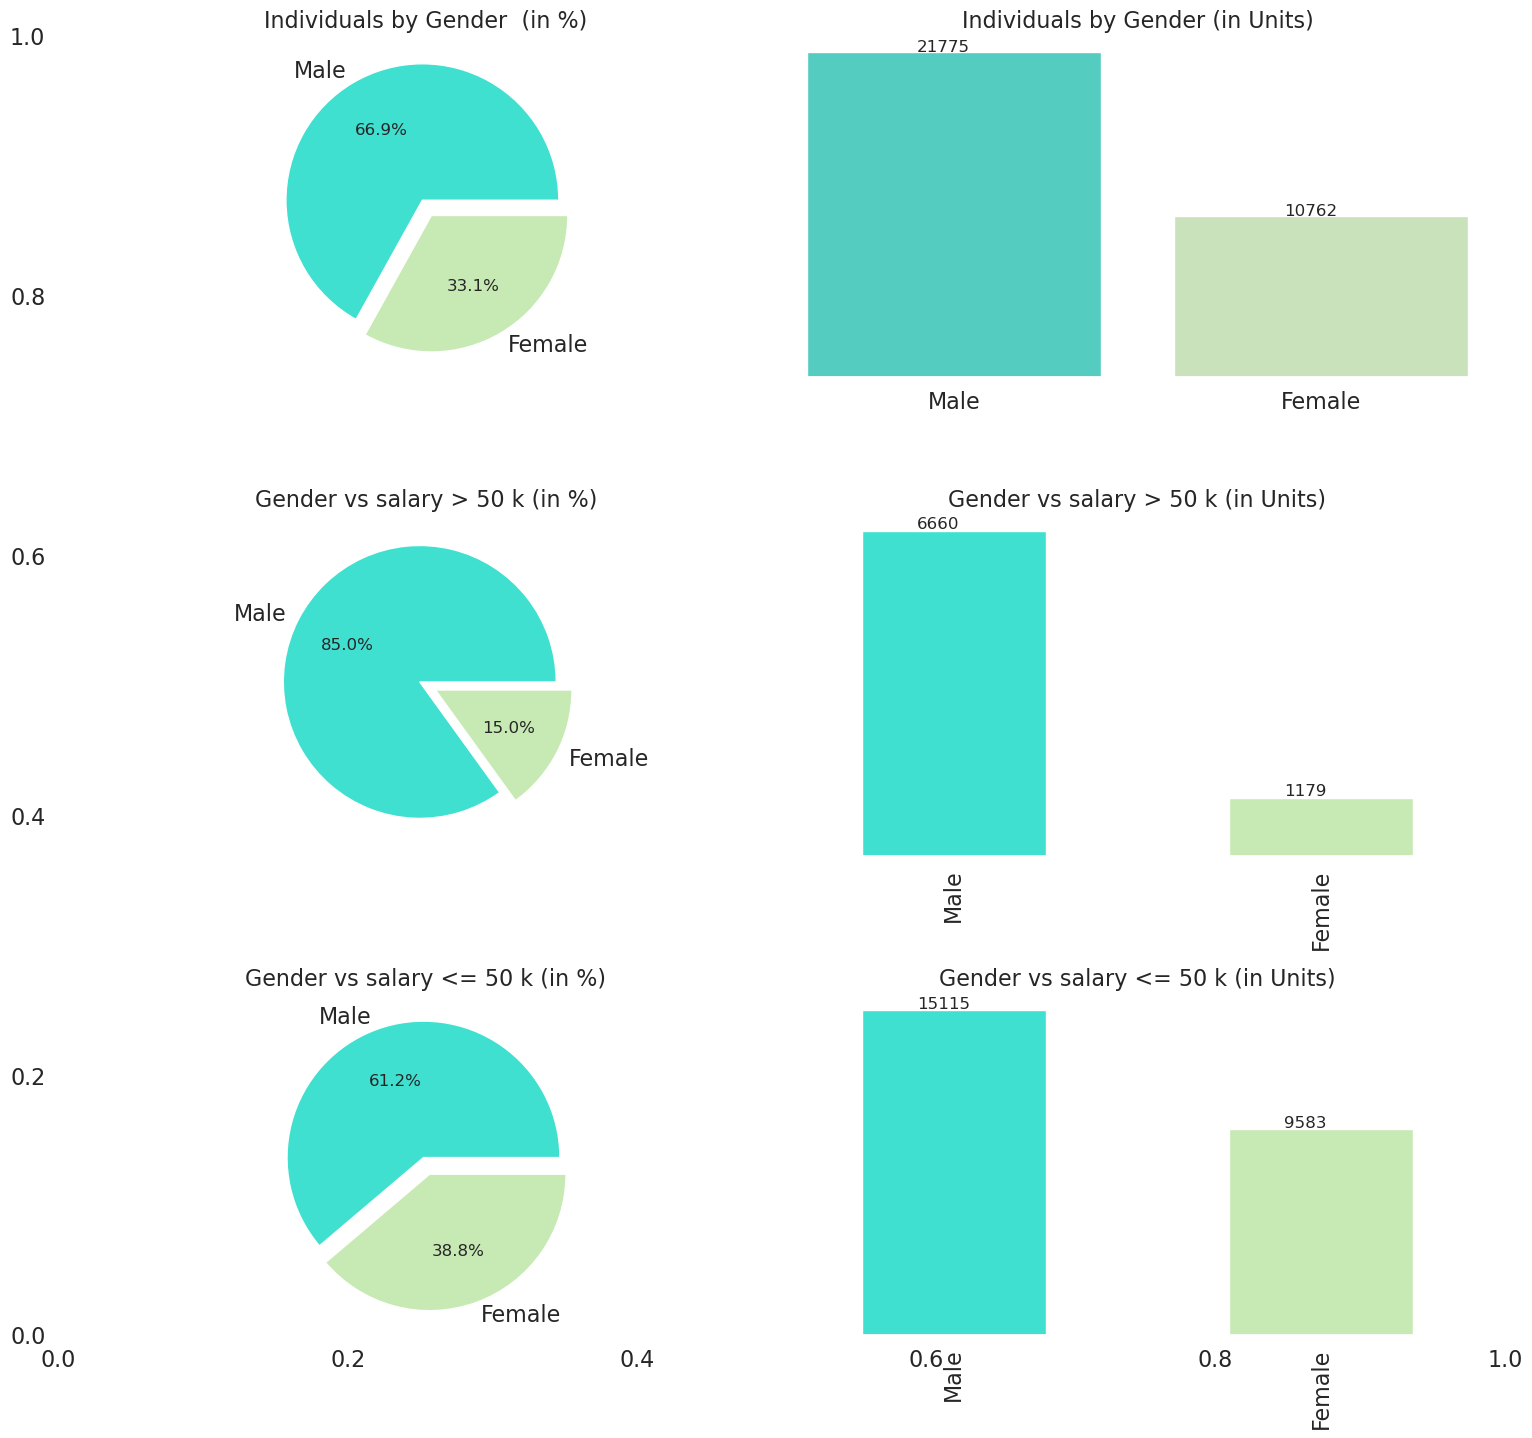

In [212]:
## Now let's analyse the categorical variables in the dataset

## Workclass, education, marital-status, occupation, relationship, race, sex, and native-country are the main categorical variables we have in our dataset

## We'll analyse a few of them, starting from Gender (sex) variable

plt.subplots(figsize=(15,15))
my_xpl = [0.05, 0.08]

## Gender (in %)
plt.subplot(3,2,1)
plt.title('Individuals by Gender  (in %)', fontsize=16)
df['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Gender (in Units)
plt.subplot(3,2,2)
plt.title('Individuals by Gender (in Units)',fontsize=16)
ax = sns.countplot(x="sex", data=df, palette=my_pal, order=df['sex'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Gender > 50 k (in %)
plt.subplot(3,2,3)
plt.title('Gender vs salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Gender > 50 k (in Units)
plt.subplot(3,2,4)
plt.title('Gender vs salary > 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='>50K']['sex'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Gender < = 50 k (in %)
plt.subplot(3,2,5)
plt.title('Gender vs salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## Gender <= 50 k (in Units)
plt.subplot(3,2,6)
plt.title('Gender vs salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['sex'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()

Some Observations

Seems some serious discrepancy in gender vs salary, as female individuals account for just 15% of the >50k salary segment.
Whereas, females account for nearly 40% of <=50k salary segment.
It seems in the USA, gender disparity is higher since the country accounts for nearly 90% of the total records.

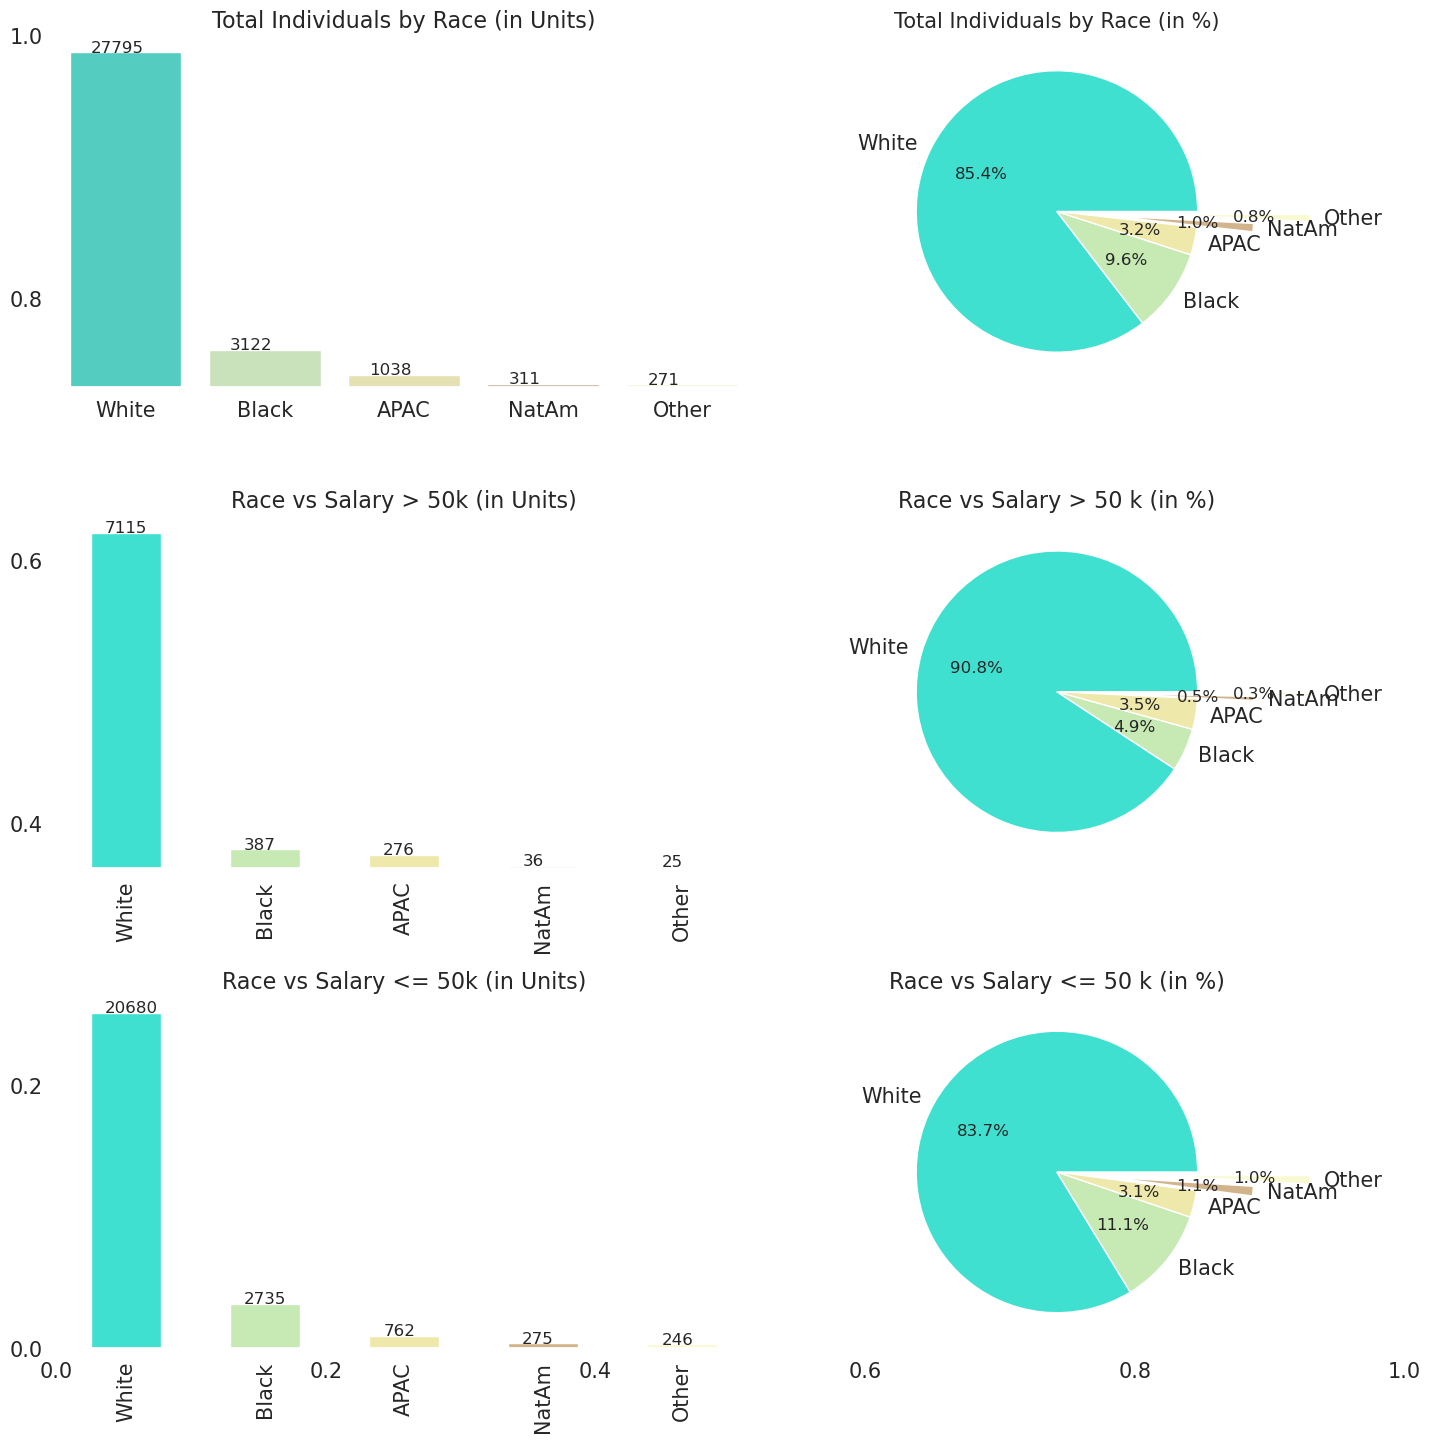

In [213]:
## Analysis of Race feature

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':15,'ytick.labelsize':15, 'figure.autolayout':True})

plt.subplots(figsize=(15,15))
my_xpl = [0, 0, 0, 0.4, 0.8]

## race total (in Units)
plt.subplot(3,2,1)
plt.title('Total Individuals by Race (in Units)', fontdict={'fontsize':16})
ax = sns.countplot(x="race", data=df, palette=my_pal, order=df['race'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+25))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary (in Units)
plt.subplot(3,2,2)
plt.title('Total Individuals by Race (in %)', fontdict={'fontsize':15})
df['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl, autopct='%1.1f%%')
 
## race by salary > 50 k (in %)
plt.subplot(3,2,3)
plt.title('Race vs Salary > 50k (in Units)', fontdict={'fontsize':16})
ax = df[df['salary']=='>50K']['race'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+8))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary  > 50 k (in %)
plt.subplot(3,2,4)
plt.title('Race vs Salary > 50 k (in %)', fontdict={'fontsize':16})
df[df['salary']=='>50K']['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl,  autopct='%1.1f%%')

## race by salary < = 50 k (in Units)
plt.subplot(3,2,5)
plt.title('Race vs Salary <= 50k (in Units)', fontdict={'fontsize':16})
ax = df[df['salary']=='<=50K']['race'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+8))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary < = 50 k (in %)
plt.subplot(3,2,6)
plt.title('Race vs Salary <= 50 k (in %)', fontdict={'fontsize':16})
df[df['salary']=='<=50K']['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl, autopct='%1.1f%%')

plt.show()

Key Observations

By Race, white people lead the table with over 85% share in total number of salaried individuals.
Furthermore, white people have above 90% share in over 50k salary category.

In [52]:
## Analysis of WORKCLASS feature
"""
plt.subplots(figsize=(15,12))
my_xpl = [0.15, 0.0, 0.0, 0.0]

## Workclass (in %)

plt.subplot(2,3,1)
plt.title('Workclass total (in %)', fontsize=16)
df['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass > 50 k (in %)

plt.subplot(2,3,2)
plt.title('Workclass vs salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass < = 50 k (in %)

plt.subplot(2,3,3)
plt.title('Workclass vs salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## Workclass (in Units)

plt.subplot(2,3,4)
plt.title('Workclass total (in Units)',fontsize=16)
ax = sns.countplot(x="workclass", data=df, palette=my_pal, order=df['workclass'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Workclass > 50 k (in Units)

plt.subplot(2,3,5)
plt.title('Workclass vs salary > 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='>50K']['workclass'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Workclass <= 50 k (in Units)

plt.subplot(2,3,6)
plt.title('Workclass vs salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['workclass'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.06, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()
"""

'\nplt.subplots(figsize=(15,12))\nmy_xpl = [0.15, 0.0, 0.0, 0.0]\n\n## Workclass (in %)\n\nplt.subplot(2,3,1)\nplt.title(\'Workclass total (in %)\', fontsize=16)\ndf[\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n## Workclass > 50 k (in %)\n\nplt.subplot(2,3,2)\nplt.title(\'Workclass vs salary > 50 k (in %)\', fontsize=16)\ndf[df[\'salary\']==\'>50K\'][\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n## Workclass < = 50 k (in %)\n\nplt.subplot(2,3,3)\nplt.title(\'Workclass vs salary <= 50 k (in %)\', fontsize=16)\ndf[df[\'salary\']==\'<=50K\'][\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n\n## Workclass (in Units)\n\nplt.subplot(2,3,4)\nplt.title(\'Workclass total (in Units)\',fontsize=16)\nax = sns.countplot(x="workclass", data=df, palette=m

Some Observations

If you observe the salary >50K pie chart (the middle one), you can understand that the share of self-employed and Govenment job holders with >50K salary is relatively higher than the respective share in total chart (first one).
And by reading the <=50K pie chart, it can be understood that the share of private employees is higher than the overall share.

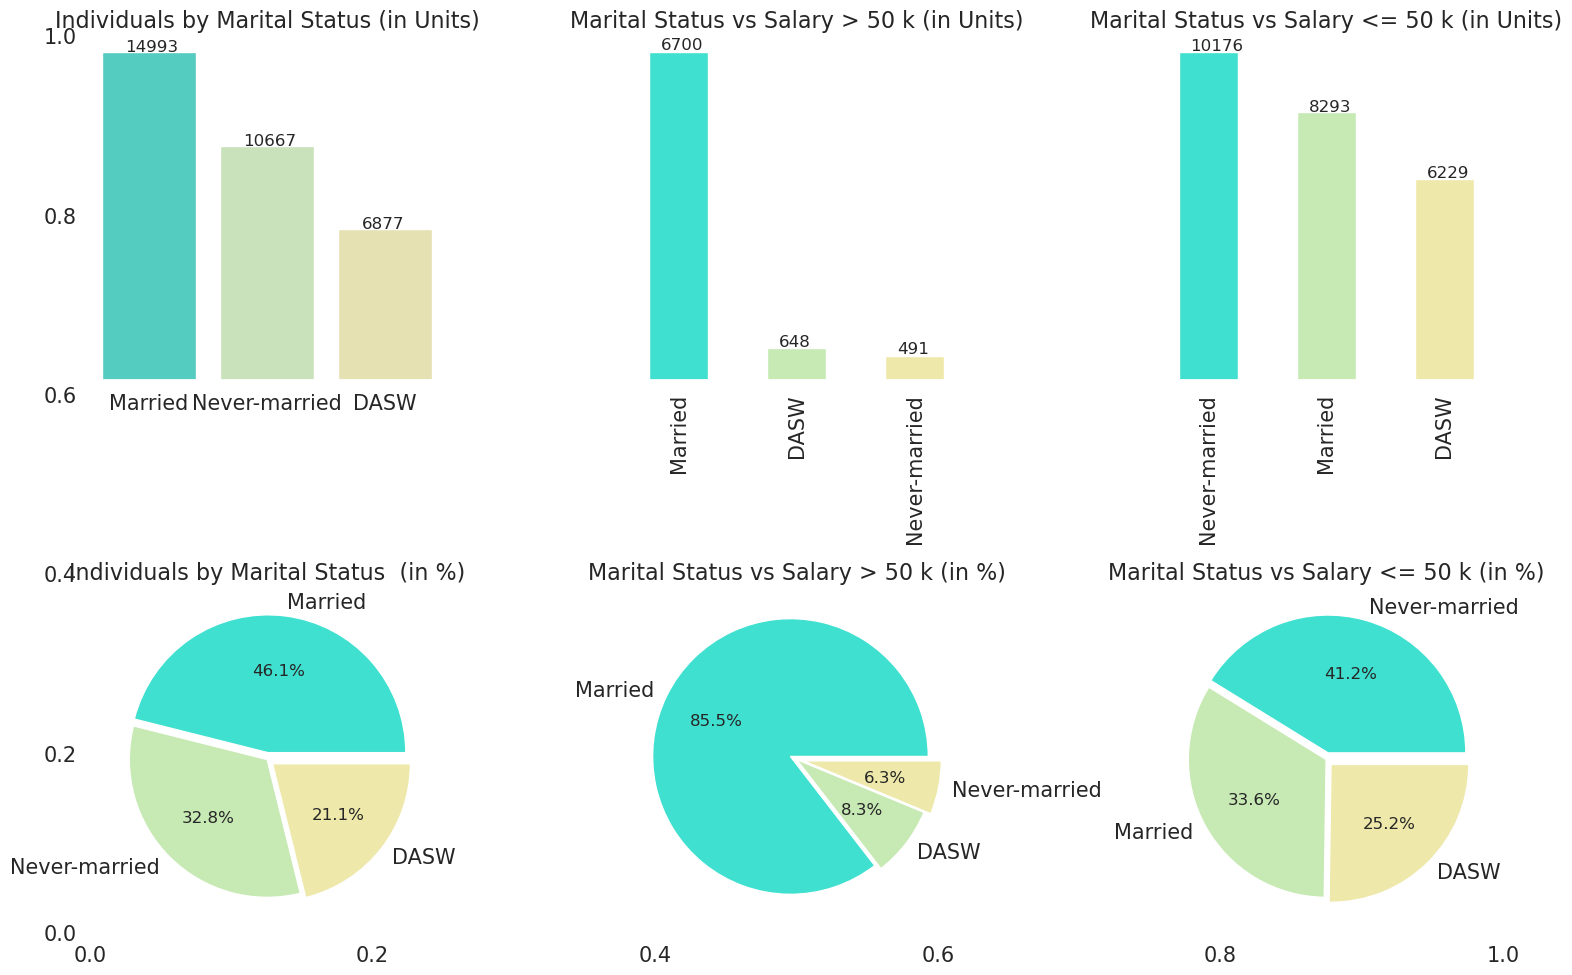

In [216]:
## Analysis of marital-status variable 

plt.subplots(figsize=(16,10))
my_xpl = [0.05, 0, 0.05]

## marital status (in Units)
plt.subplot(2,3,1)
plt.title('Individuals by Marital Status (in Units)', fontsize=16)
ax = sns.countplot(x="marital-status", data=df, palette=my_pal, order=df['marital-status'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## marital status > 50 k (in Units)
plt.subplot(2,3,2)
plt.title('Marital Status vs Salary > 50 k (in Units)',fontsize=16)
ax = df[df['salary']=='>50K']['marital-status'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)
    
## marital status <= 50 k (in Units)
plt.subplot(2,3,3)
plt.title('Marital Status vs Salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['marital-status'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## marital status (in %)
plt.subplot(2,3,4)
plt.title('Individuals by Marital Status  (in %)', fontsize=16)
df['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## marital status > 50 k (in %)
plt.subplot(2,3,5)
plt.title('Marital Status vs Salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass < = 50 k (in %)
plt.subplot(2,3,6)
plt.title('Marital Status vs Salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

plt.show()

Some Observations

From the above plots, it is understood that Married people have higher salary, and comprise around 85% of total above 50K salaried individuals.

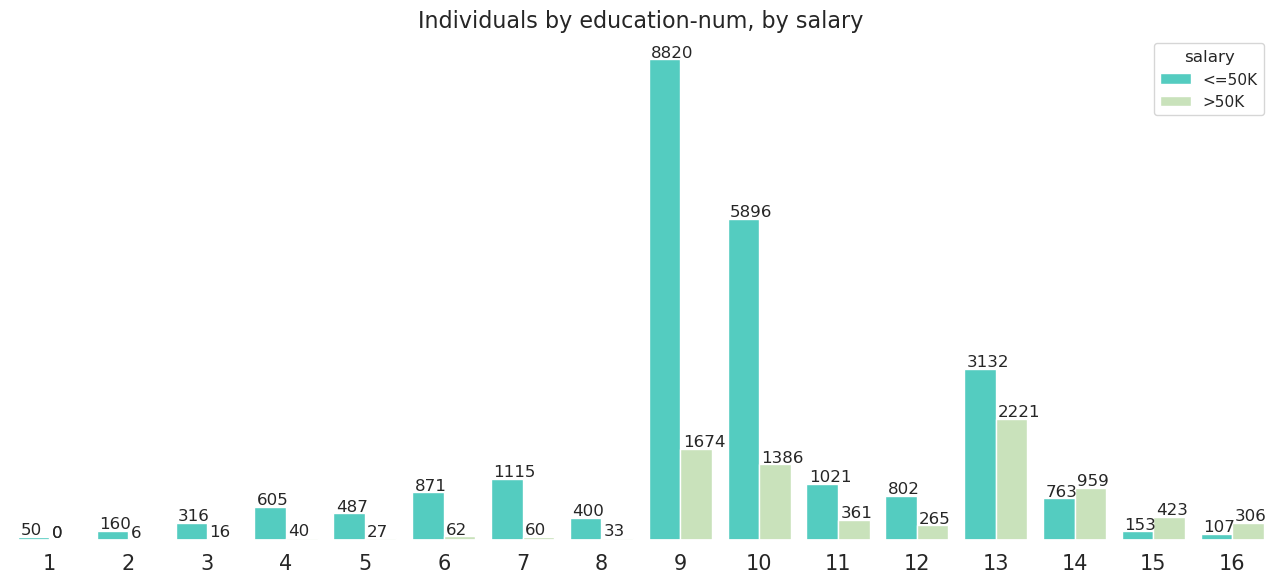

In [217]:
## Before proceeding to modeling, let's have a look at education-num feature

plt.figure(figsize=(13,6))

plt.title('Individuals by education-num, by salary', fontsize=16)
ax = sns.countplot(x='education-num', hue='salary', palette=my_pal, data=df)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.03, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()

Some Observations

The education number 9 (i.e., high School graduate) is largest of the lot, by far.
Above 50K salary is relatively much higher than <=50K for individuals with education number 14 (Masters), education number 15 (Professional school), and education number 16 (Doctorate).
And it is vice versa for education number 1 through to 8.
All in all, number of individuals is higher from education number 9 to education number 13.

In [16]:
## Okay, we will stop our eda there, and start with Model Building & Machine Learning

## Grouping the features into numerical & categorical 

num_df = df[['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']] 
cat_df = df[['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country', 'salary']]

In [17]:
data_encoded = df.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in cat_df.columns.to_list():
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])

    categorical_names[feature] = le.classes_
    encoders[feature] = le

"""
for k, v in categorical_names.items():
    print(f"k: {k}, v: {v}")

for k, v in encoders.items():
    print(f"k: {k}, v: {v}")
"""

'\nfor k, v in categorical_names.items():\n    print(f"k: {k}, v: {v}")\n\nfor k, v in encoders.items():\n    print(f"k: {k}, v: {v}")\n'

In [29]:
print(df.shape)
print(data_encoded.shape)

(32537, 15)
(32537, 15)


In [18]:
def decode_dataset(data, encoders, categorical_features):
    df = data.copy()

    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [31]:
numerical_features = num_df.columns.to_list()
categorical_features = cat_df.columns.to_list()

result = decode_dataset(data_encoded, encoders, categorical_features)

print("## RESULT : ORIGINAL ##")
print(result.head())

print("## DATA ENCODED : READY FOR THE MODEL ##")
print(data_encoded.head())

## RESULT : ORIGINAL ##
   age workclass  fnlwgt  education  education-num marital-status  \
0   39     Govt.   77516  Bachelors             13  Never-married   
1   50  self_emp   83311  Bachelors             13        Married   
2   38   Private  215646    HS-grad              9           DASW   
3   53   Private  234721       11th              7        Married   
4   28   Private  338409  Bachelors             13        Married   

      occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Adminstration  Not-in-family  White    Male          2174             0   
1      Executive        Husband  White    Male             0             0   
2       Handlers  Not-in-family  White    Male             0             0   
3       Handlers        Husband  Black    Male             0             0   
4   Profesionals           Wife  Black  Female             0             0   

   hours-per-week native-country salary  
0              40            USA  <=50K  
1       

In [20]:
## Now we check the corrleation of features with the target variable (salary)
main_df = data_encoded.copy()
corr_matrix = main_df.corr()
corr_matrix['salary'].sort_values(ascending=False)

salary            1.00
education-num     0.34
age               0.23
hours-per-week    0.23
capital-gain      0.22
sex               0.22
capital-loss      0.15
workclass         0.09
education         0.08
race              0.07
native-country    0.02
fnlwgt           -0.01
occupation       -0.04
marital-status   -0.11
relationship     -0.25
Name: salary, dtype: float64

In [21]:
## Segregating the Dependent Variable in Y-axis and Independent Variables in X-axis
## And removing the features that are considered insignificant

X = main_df.drop(columns=["salary", "fnlwgt"])
# other variables to potentially drop: "education", "race", "workclass", "native-country", "occupation", "marital-status"
y = main_df["salary"]

In [35]:
for col in X.columns:
    print(col)

age
workclass
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country


In [36]:
## Splitting the Data 
## We split the data into train & test sets in 80:20 ratio

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print('-'*34, '\n', f'\033[94mTrain data & Test data shapes', '\n', f'\033[94m '*14, f'\033[94mX            y')
print('-'*34, '\n', f'\033[94mTrain data | ', X_train.shape, y_train.shape, '\n', f'\033[94mTest data  | ', X_test.shape, y_test.shape)

---------------------------------- 
 Train data & Test data shapes 
                X            y
---------------------------------- 
 Train data |  (26029, 13) (26029,) 
 Test data  |  (6508, 13) (6508,)


In [37]:
## Defining & running the Classifier Models

Model = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ] 

# Logging for Visual Comparison
log_cols=["Model", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in Model:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print(f'\033[94m-'*30, '\n')
    print(name)
    
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    print("Accuracy: {:.5%}".format(acc))
    
    test_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, test_predictions)
    print("Log Loss: {:.5}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    #log = log.append(log_entry)
    log = pd.concat([log, log_entry])
print(f'\033[94m-'*30)

------------------------------ 

DecisionTreeClassifier
Accuracy: 81.94530%
Log Loss: 5.8474
------------------------------ 

RandomForestClassifier
Accuracy: 85.06454%
Log Loss: 0.46627
------------------------------


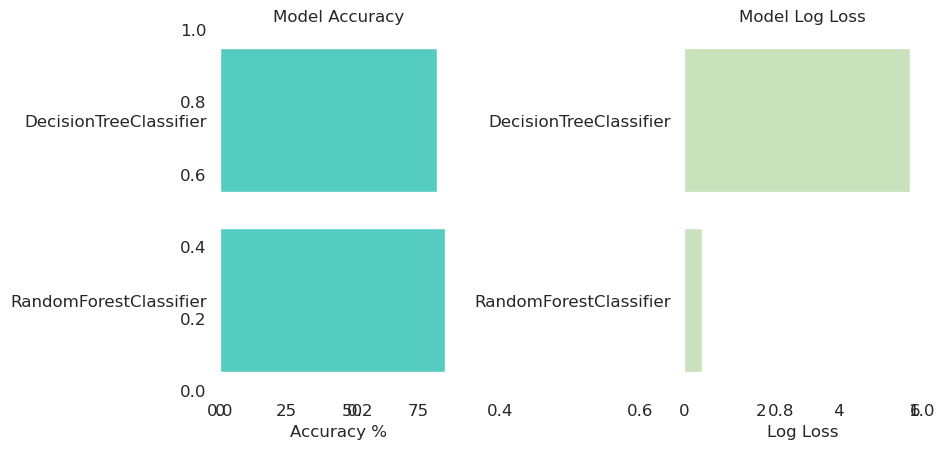

In [38]:
## Visualising the accuracy & log loss data

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':12,'ytick.labelsize':12, 'figure.autolayout':True})
plt.subplots(figsize=(10,5))

plt.subplot(1,2,1)
sns.set_color_codes("bright")
sns.barplot(x='Accuracy', y='Model', data=log, color='#40E0D0')
plt.title('Model Accuracy', fontdict={'fontsize':12})
plt.ylabel(None), plt.xlabel('Accuracy %')

plt.subplot(1,2,2)
sns.set_color_codes("bright")
sns.barplot(x='Log Loss', y='Model', data=log, color='#c7e9b4')
plt.title('Model Log Loss', fontdict={'fontsize':12})
plt.ylabel(None), plt.xlabel('Log Loss')

plt.show()

Accuracy: 85 % 

Confusion Matrix in Numbers
[[4577  363]
 [ 593  975]]


 Confusion Matrix in Percentage
[[0.93 0.07]
 [0.38 0.62]]



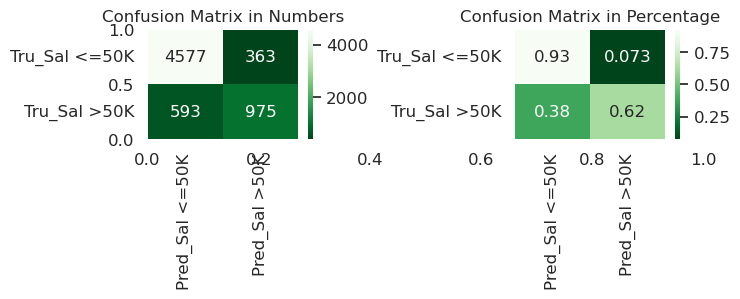

In [39]:
## We saw that RandomForestClassifier is the best classifier of the lot
## So let's acknowledge it, and prepare confusion matrix for the classifier for train data

mod_RF = RandomForestClassifier()
mod_RF.fit(X_train, y_train)

y_pred_RF = mod_RF.predict(X_test)
acc_RF = round(mod_RF.score(X_test, y_test) * 100, 2)
print ("Accuracy: %i %% \n"%acc_RF)

class_names = ['Salary <=50K', 'Salary >50K']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_RF)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('\n', 'Confusion Matrix in Percentage')
print (cnf_matrix_percent)
print ('')

true_class_names = ['Tru_Sal <=50K', 'Tru_Sal >50K']
predicted_class_names = ['Pred_Sal <=50K', 'Pred_Sal >50K']

main_df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

main_df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.subplots(figsize = (8,3.5))

plt.subplot(1,2,1)
plt.title("Confusion Matrix in Numbers", fontdict={'fontsize':12})
sns.heatmap(main_df_cnf_matrix, cmap='Greens_r', annot=True, fmt='d')

plt.subplot(1,2,2)
plt.title("Confusion Matrix in Percentage", fontdict={'fontsize':12})
sns.heatmap(main_df_cnf_matrix_percent, cmap='Greens_r', annot=True)

plt.show()

In [40]:
### Prepare a classification report for test data with XGBClassifier

print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4940
           1       0.73      0.62      0.67      1568

    accuracy                           0.85      6508
   macro avg       0.81      0.77      0.79      6508
weighted avg       0.85      0.85      0.85      6508



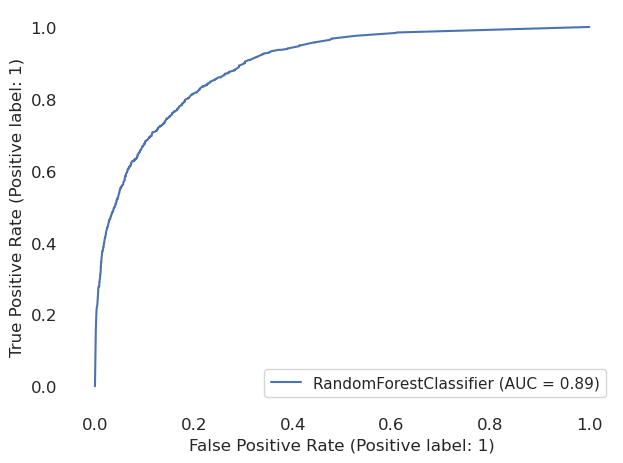

In [41]:
# Plot ROC curve and calculate AUC metric for test data with XGBClassifier

RF_disp = RocCurveDisplay.from_estimator(mod_RF, X_test, y_test)

In [42]:
# Save the data, the model, train and test dataset, preprocessed dataset
# df.to_parquet("./data/salary_prediction_data.parquet")
# joblib.dump(mod_RF, "./data/salary_prediction_model_RF.pkl")

['./data/salary_prediction_model_RF.pkl']

In [91]:
print(X.columns.to_list())

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [92]:
print(y[0:10])

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: salary, dtype: int64


In [97]:
print(type(X_train))
print(type(y_train))

X_train_set = pd.DataFrame(X_train)
y_train_set = y_train.to_frame()

X_test_set = pd.DataFrame(X_test)
y_test_set = y_test.to_frame()

print(f"X_train_set shape: {X_train_set.shape}")
print(f"y_train shape: {y_train_set.shape}")

X_train_set.columns = X.columns.to_list()
y_train_set.columns = ["salary"]

X_test_set.columns = X.columns.to_list()
y_test_set.columns = ["salary"]

print(f"X_train_set shape: {X_train_set.shape}")
print(f"y_train shape: {y_train_set.shape}")

X_train_set.to_parquet("./data/X_train_set.parquet")
y_train_set.to_parquet("./data/y_train_set.parquet")
X_test_set.to_parquet("./data/X_test_set.parquet")
y_test_set.to_parquet("./data/y_test_set.parquet")

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
X_train_set shape: (26029, 13)
y_train shape: (26029, 1)
X_train_set shape: (26029, 13)
y_train shape: (26029, 1)


In [103]:
print(result.groupby(["sex"]).count()["age"])

sex
Female    10762
Male      21775
Name: age, dtype: int64


In [104]:
print(data_encoded.groupby(["sex"]).count()["age"])

sex
0    10762
1    21775
Name: age, dtype: int64


In [ ]:
X_train_set.reset_index(drop=True, inplace=True)
y_train_set.reset_index(drop=True, inplace=True)

In [5]:
# Read saved data and model if needed.
import pandas as pd
import joblib

X_train_set = pd.read_parquet("./data/X_train_set.parquet")
y_train_set = pd.read_parquet("./data/y_train_set.parquet")
X_test_set = pd.read_parquet("./data/X_test_set.parquet")
y_test_set = pd.read_parquet("./data/y_test_set.parquet")

print(X_train_set.shape)
print(y_train_set.shape)

mod_RF = joblib.load("./data/salary_prediction_model_RF.pkl")

(26029, 13)
(26029, 1)


In [4]:
Xy = pd.concat([X_train_set, y_train_set], axis=1)

print(X_train_set.shape)
print(y_train_set.shape)
print(Xy.shape)

(26029, 13)
(26029, 1)
(26029, 14)


In [113]:
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Assume 'df' is your pandas DataFrame with columns 'sex' and 'salary'

# Define favorable and unfavorable labels
favorable_label = 1      # Define the value in 'salary' column that indicates a favorable outcome
unfavorable_label = 0    # Define the value in 'salary' column that indicates an unfavorable outcome

# Create the BinaryLabelDataset
# ref. https://github.com/Trusted-AI/AIF360/blob/main/aif360/datasets: BinaryLabelDataset

dataset = BinaryLabelDataset(
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label,
    df=Xy,
    label_names=['salary'],                   # The target column in the DataFrame
    protected_attribute_names=['sex']          # The protected attribute in the DataFrame
)

# Display the dataset to verify
print("BinaryLabelDataset created:")
print("Features:", dataset.features)
print("Labels:", dataset.labels)
print("Protected attribute names:", dataset.protected_attribute_names)

BinaryLabelDataset created:
Features: [[26.  2. 11. ...  0. 40. 22.]
 [20.  2.  8. ...  0. 40. 39.]
 [29.  1.  9. ...  0. 40. 39.]
 ...
 [46.  2.  0. ...  0. 40. 39.]
 [22.  2.  9. ...  0. 16. 39.]
 [35.  4.  9. ...  0. 60. 39.]]
Labels: [[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
Protected attribute names: ['sex']


In [114]:
# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# Create the metric object
metric = BinaryLabelDatasetMetric(dataset, 
                                  privileged_groups=privileged_groups, 
                                  unprivileged_groups=unprivileged_groups)

# Calculate statistical parity difference
statistical_parity_difference = metric.mean_difference()
disparate_impact = metric.disparate_impact()
consistency = metric.consistency()

print("Statistical Parity Difference:", statistical_parity_difference)

Statistical Parity Difference: -0.1971944841813123


In [ ]:
# Mitigate bias by transforming the original dataset

In [116]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset)

In [119]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
